# Part 5: Basic Panoramic Image

### For this part and the next part, you can use any set of images (even images taken by yourself) that support your implementation. You must include the images in your submission.

1. Using SIFT and RANSAC for computing the homography matrices, create a program to generate panoramic images given ordered images. Using as many provided images as you can, show the output of your panoramic image.

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

In [15]:
# load the images
im01 = cv2.imread('part1_4/im01.jpg')
im01 = cv2.cvtColor(im01, cv2.COLOR_BGR2RGB)
im02 = cv2.imread('part1_4/im02.jpg')
im02 = cv2.cvtColor(im02, cv2.COLOR_BGR2RGB)
im03 = cv2.imread('part1_4/im03.jpg')
im03 = cv2.cvtColor(im03, cv2.COLOR_BGR2RGB)
im04 = cv2.imread('part1_4/im04.jpg')
im04 = cv2.cvtColor(im04, cv2.COLOR_BGR2RGB)
im05 = cv2.imread('part1_4/im05.jpg')
im05 = cv2.cvtColor(im05, cv2.COLOR_BGR2RGB)


In [16]:
sift = cv2.SIFT_create()

im01_gray = cv2.cvtColor(im01, cv2.COLOR_BGR2GRAY)
im02_gray = cv2.cvtColor(im02, cv2.COLOR_BGR2GRAY)
im03_gray = cv2.cvtColor(im03, cv2.COLOR_BGR2GRAY)
im04_gray = cv2.cvtColor(im04, cv2.COLOR_BGR2GRAY)
im05_gray = cv2.cvtColor(im05, cv2.COLOR_BGR2GRAY)

kp1, des1 = sift.detectAndCompute(im01_gray, None)
kp2, des2 = sift.detectAndCompute(im02_gray, None)
kp3, des3 = sift.detectAndCompute(im03_gray, None)
kp4, des4 = sift.detectAndCompute(im04_gray, None)
kp5, des5 = sift.detectAndCompute(im05_gray, None)

In [17]:
def match(des1, des2):
    best1 = np.zeros(des1.shape[0])
    best2 = np.zeros(des2.shape[0])

    for i in range(des1.shape[0]):
        distant = np.zeros(des2.shape[0])
        for j in range(des2.shape[0]):
            distant[j] = np.sum((des1[i] - des2[j]) ** 2)
        best1[i] = int(np.argmin(distant))
    
    for i in range(des2.shape[0]):
        distant = np.zeros(des1.shape[0])
        for j in range(des1.shape[0]):
            distant[j] = np.sum((des2[i] - des1[j]) ** 2)       
        best2[i] = int(np.argmin(distant))
    
    best1 = best1.astype(int)
    best2 = best2.astype(int)

    matches = []
    for i in range(best1.shape[0]):
        m = best1[i]
        n = best2[m]
        if i == n:
            matches.append([n, m])
            
    return matches

In [18]:
def matchesLines(im01, im02, matches):
    imgs_matches = np.concatenate((im01,im02),axis = 1)
    colors = [
        (255, 0, 0),     
        (0, 255, 0),     
        (0, 0, 255),     
        (255, 255, 0),   
        (255, 0, 255),   
        (0, 255, 255),   
        (128, 128, 128), 
        (0, 0, 0),       
        (255, 255, 255)  
    ]

    for i in range(len(matches)):
        x1 = kp1[int(matches[i][0])].pt[0]
        y1 = kp1[int(matches[i][0])].pt[1]
        x2 = kp2[int(matches[i][1])].pt[0]
        y2 = kp2[int(matches[i][1])].pt[1]
        color_idx = random.randint(0,8)
        cv2.line(imgs_matches,(int(x1),int(y1)),(int(x2)+im01.shape[1],int(y2)),colors[color_idx],1)
    
    plt.imshow(imgs_matches)
    plt.axis('off')
    plt.show()

In [19]:
def homography(points_1, points_2):
    points_1 = np.column_stack((points_1, np.ones(len(points_1))))
    points_2 = np.column_stack((points_2, np.ones(len(points_2))))

    A = np.zeros((2*len(points_1),9))
    for i in range(len(points_1)):
        x1, y1, _ = points_1[i]
        x2, y2, _ = points_2[i]
        A[2*i] = [x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2, -x2]
        A[2*i + 1] = [0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2, -y2]

    U, D, V_T = np.linalg.svd(A)
    h = V_T[-1]
    H = h.reshape((3,3))
    H = H / H[2,2]
    return H

In [20]:

def RANSAC_homography(kp1, kp2, matches, iteration_times):
    n = 5
    final_H = []
    epsion = 1 # threshold of the distance of inliers
    N = len(matches)
    max_inliers = []
    
    for k in range(iteration_times):
        rdm = random.sample(range(0, N), 5)
        points_1 = []
        points_2 = []
        for j in range(n):
            points_1.append([kp1[int(matches[rdm[j]][0])].pt[0], kp1[int(matches[rdm[j]][0])].pt[1]])
            points_2.append([kp2[int(matches[rdm[j]][1])].pt[0], kp2[int(matches[rdm[j]][1])].pt[1]])

        H = homography(points_1, points_2)
        
        inliers = []
        
        for i in range(N):
            x1 = kp1[int(matches[i][0])].pt[0]
            y1 = kp1[int(matches[i][0])].pt[1]
            x2 = kp2[int(matches[i][1])].pt[0]
            y2 = kp2[int(matches[i][1])].pt[1]
            
            hx1, hy1, hz1 = np.dot(H, [x1, y1, 1])
            hx1 = int(hx1 / hz1)
            hy1 = int(hy1 / hz1)
            distance = np.sqrt((x2 - hx1) ** 2 + (y2 - hy1) ** 2)

            if distance < epsion:
                inliers.append(matches[i])
        
        if len(inliers) > len(max_inliers):
            max_inliers = inliers
    
    points_1 = []
    points_2 = []
    for i in range(len(max_inliers)):
        points_1.append([kp1[int(max_inliers[i][0])].pt[1], kp1[int(max_inliers[i][0])].pt[0]])
        points_2.append([kp2[int(max_inliers[i][1])].pt[1], kp2[int(max_inliers[i][1])].pt[0]])
    final_H = homography(points_1, points_2) 

    return final_H, max_inliers

In [21]:
def transform(img01, img02, H):
    # Transform img01 to img02, H is the homography matrix from img01 to img02

    # 1. Get the size of transformed img01 
    rec_points = [[0,0],[img01.shape[0], 0], [img01.shape[0], img01.shape[1]],[0, img01.shape[1]]]
    transformed_rec_points = []
    for point in rec_points:
        x = point[0]
        y = point[1]
        i,j,k = np.dot(H, [x, y, 1])
        i = int(i/ k)
        j = int(j/k)
        transformed_rec_points.append([i, j])

    # 2. Compute the size of canvas
    canvas_height = img02.shape[0]
    canvas_width = img02.shape[1]

    min_i = min(point[0] for point in transformed_rec_points)
    max_i = max(point[0] for point in transformed_rec_points)
    min_j = min(point[1] for point in transformed_rec_points)
    max_j = max(point[1] for point in transformed_rec_points)

    canvas_height = max(max_i, canvas_height) - min(0, min_i) + 1
    canvas_width = max(max_j, canvas_width) - min(0, min_j) + 1
    
    # 3. Create Canvas
    canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8)
    canvas[abs(min(0, min_i)): abs(min(0, min_i))+img02.shape[0], abs(min(0, min_j)): abs(min(0, min_j))+img02.shape[1]] = img02

    # 4. For every point in the size of transformed img01, use the inverse of H to find the original point of img01
    for i in range(min_i, max_i):
        for j in range(min_j, max_j):
            x, y, z = np.dot(np.linalg.inv(H), [i, j, 1])
            x = int(x/z)
            y = int(y/z)
            if 0<=x< img01.shape[0] and 0<=y<img01.shape[1]:
                canvas[i + abs(min(0, min_i)), j + abs(min(0, min_j))] = img01[x,y]
    return canvas

stitch im02 to im01

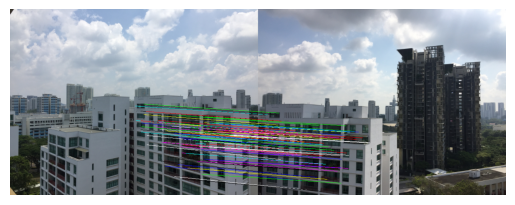

In [22]:
matches = match(des1, des2)
H12, inliers = RANSAC_homography(kp1, kp2, matches, 10000)
matchesLines(im01, im02, inliers)

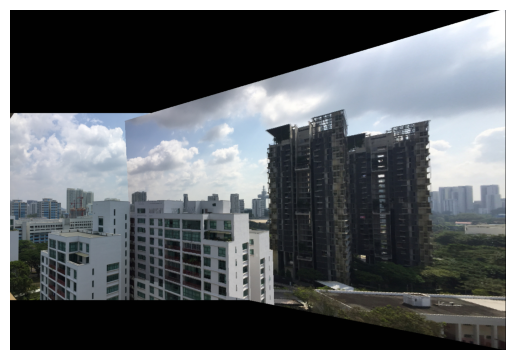

In [23]:
canvas = transform(im02, im01, np.linalg.inv(H12))
plt.imshow(canvas)
plt.axis('off')
plt.show()

stitch im03 to im21

In [26]:
im21 = canvas
im21_gray = cv2.cvtColor(im21, cv2.COLOR_BGR2GRAY)
kp21, des21 = sift.detectAndCompute(im21_gray, None)
matches = match(des21, des3)
H23, inliers = RANSAC_homography(kp21, kp3, matches, 10000)

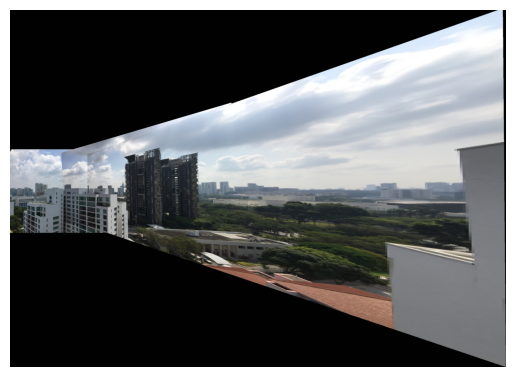

In [29]:
canvas = transform(im03, im21, np.linalg.inv(H23))
plt.imshow(canvas)
plt.axis('off')
plt.show()

stitch im04 to im321

In [30]:
im321 = canvas
im321_gray = cv2.cvtColor(im321, cv2.COLOR_BGR2GRAY)
kp321, des321 = sift.detectAndCompute(im321_gray, None)
matches = match(des321, des4)
H34, inliers = RANSAC_homography(kp321, kp4, matches, 10000)

The stitching process is too big to proceeding.

In [32]:
canvas = transform(im04, im321, np.linalg.inv(H34))
plt.imshow(canvas)
plt.axis('off')
plt.show()

KeyboardInterrupt: 